<a href="https://colab.research.google.com/github/ArBioIIMAS/8taEscuela_invierno2025/blob/main/notebooks/P3_Training_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Taller: Visión computacional e IA (parte 3)

El objetivo de esta libreta es construir un modelo para segmentar imágenes basedo en redes neuronales profundas (deep learning).



---



## Machine learning vs Deep learning

![Alt text](https://images.prismic.io/turing/652ebc26fbd9a45bcec81819_Deep_Learning_vs_Machine_Learning_3033723be2.webp?auto=format%2Ccompress&fit=max&w=1920 "ML vs DL")

Imagen tomada de [turing.com](https://www.turing.com/)

## Redes neuronales

Una red neuronal es un modelo matemático inspirado en el comportamiento biológico de las neuronas y en la estructura del cerebro.

![Alt text](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F51639b29-d664-4572-93a6-01f891ff027e_1197x457.png "Artificial neural network vs Biological neural network")

Imagen tomada de [Cody Isabel | Neuroscience ](https://substack.com/@mindbrainbodylab)




## Redes convolucionales

Una red neuronal convolucional (CNN) es un tipo de arquitectura de red neuronal de aprendizaje profundo comúnmente utilizada en visión artificial.

![Alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/0*YVT_vA0cgiwkKkPX.png "CNN")

Imagen tomada de medium.com

# U-Net architecture

La U-Net es una arquitectura de red convolucional dedicado a tareas de visión computacional (Computer Vision) y más concretamente a problemas de segmentación de imágenes.

La red U-Net es una de las más utilizadas para la segmentación de imágenes. Consta de un modelo de red neuronal totalmente convolucional. Este modelo fue desarrollado originalmente por Olaf Ronneberger, Phillip Fischer y Thomas Brox en 2015 para la segmentación de imágenes médicas.

La arquitectura de U-NET consta de dos «vías». La primera es la de la contracción, también llamada codificador. Se utiliza para captar el contexto de una imagen. Está compuesta por un conjunto de capas de convolución y de capas de «max pooling» que permiten crear un mapa de características de una imagen y reducir su tamaño para disminuir el número de parámetros de la red.

La segunda vía es la de la de expansión simétrica, también llamada descodificador. También permite una localización precisa mediante la convolución transpuesta

![Alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png "Arquitectura U-Net")

Imagen tomada de [vision](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

Para mayor información:
* [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
* [Artículo U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)



---



## Paso 1: Conexión con Google Drive, instalación y carga de bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls
%cd /content/drive/MyDrive/

drive  sample_data
/content/drive/MyDrive


In [3]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

## Paso 2: Modelo U-Net

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


In [5]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p

In [6]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)
        return self.conv(x)

In [7]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out


## Paso 3: Carga de datos

In [8]:
import random
import torchvision.transforms as T

class RandomChoice(torch.nn.Module):
    def __init__(self, transforms):
       super().__init__()
       self.transforms = transforms

    def __call__(self, imgs):
        t = random.choice(self.transforms)
        return [t(img) for img in imgs]

In [9]:
class Dataset_cars(Dataset):
    def __init__(self, root_path, path_images, path_masks, filenames, transform = None):
      self.root_path=root_path
      self.path_images=path_images
      self.path_masks=path_masks
      self.filenames=filenames
      self.transform=transform

    def __len__(self):
        return len(self.path_images)

    def __getitem__(self, idx) :
        for file_name in self.filenames:
          image_path = os.path.join(self.root_path + self.path_images,file_name)
          mask_path = os.path.join(self.root_path + self.path_masks,file_name)

          ## Carga de imagen
          image = Image.open(image_path).convert("RGB")

          ## Carga de máscara / etiqueta
          mask =  Image.open(mask_path).convert("L")

          ## Aplicando normalización
          normalize_img = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
          normalize_mask = v2.Compose([v2.Normalize(mean=[0.406],std=[0.225])])

          # ----- Data augmentation ---- #
          transform = RandomChoice([T.RandomHorizontalFlip(), T.RandomVerticalFlip()])
          image,mask = self.transform([image,mask])
          image = normalize_img(image)

          #if self.transform:
              #image,mask = self.transform([image,mask])
              #image = normalize_img(image)
              #mask = self.transform(mask)
          return image, mask

In [10]:
#Configuración de parámetros
batch_size = 5
lr = 3e-4
EPOCHS = 10
root_path = "8taEscuela_invierno2025/data" #ubicación de las imágenes

In [11]:
# ----- Data augmentation ---- #

train_transform = v2.Compose([v2.Resize((224,224)),
                              v2.CenterCrop(224),
                              v2.RandomHorizontalFlip(),
                              v2.RandomRotation(degrees=(0, 180)),
                              v2.RandomPerspective(distortion_scale=0.6, p=1.0),
                              v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                              ])

val_transform = v2.Compose([v2.Resize((224,224)),
                              v2.CenterCrop(224),
                              v2.RandomHorizontalFlip(),
                              v2.RandomRotation(degrees=(0, 180)),
                              v2.RandomPerspective(distortion_scale=0.6, p=1.0),
                              v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
                              ])

test_transform = v2.Compose([v2.Resize((224,224)),
                              v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),])

#Iterando sobre las carpetas de entrenamiento, validación y prueba
train_filenames = next(os.walk("8taEscuela_invierno2025/data/train"))[2]
val_filenames = next(os.walk("8taEscuela_invierno2025/data/val"))[2]
test_filenames = next(os.walk("8taEscuela_invierno2025/data/test"))[2]

train_data = Dataset_cars(root_path = root_path,
                          path_images = "/train/",
                          path_masks = "/train_masks/",
                          filenames = train_filenames,
                          transform= train_transform)

val_data = Dataset_cars(root_path = root_path,
                          path_images = "/val/",
                          path_masks = "/val_masks/",
                          filenames = val_filenames,
                          transform= val_transform)

test_data = Dataset_cars(root_path = root_path,
                          path_images = "/test/",
                          path_masks = "/test_masks/",
                          filenames = test_filenames,
                          transform= test_transform)

train_dataloader=DataLoader(train_data, batch_size=batch_size)
val_dataloader=DataLoader(val_data, batch_size=batch_size)
test_dataloader=DataLoader(test_data, batch_size=batch_size)

### Visualización del conjunto de entrenamiento

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(15, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()



 ****** Visualizing data ******


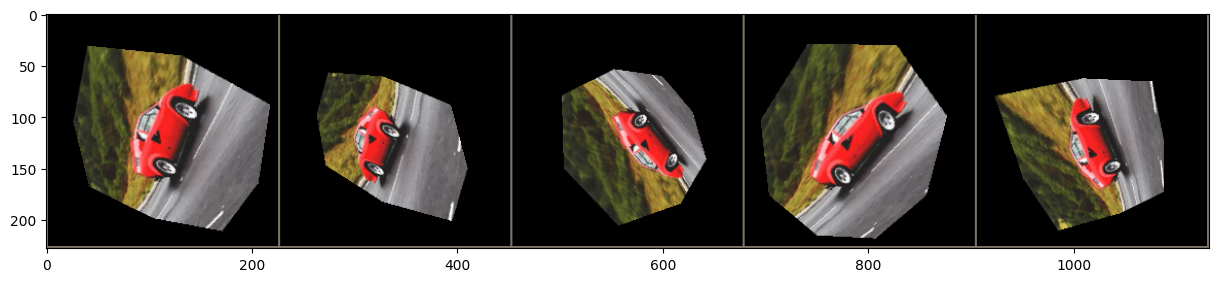

In [13]:
print("\n\n ****** Visualizing data ******")
imgs, mks = next(iter(train_dataloader)) # Get a batch of training data
out_imgs = torchvision.utils.make_grid(imgs) # Make a grid from batch
imshow(out_imgs)

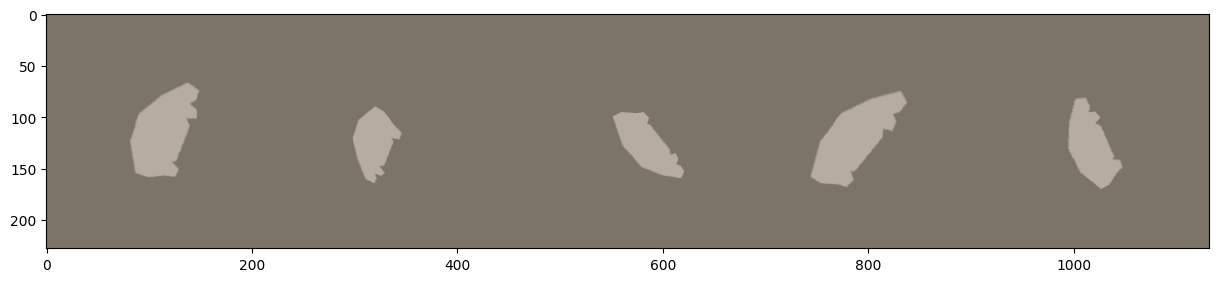

In [14]:
out_mks = torchvision.utils.make_grid(mks) # Make a grid from batch
imshow(out_mks)

In [15]:
#Configurando el dispositivo en pytorch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == "cuda":
    num_workers = torch.cuda.device_count() * 4
    print("num_workers: ", num_workers)
torch.cuda.empty_cache()

cpu


In [16]:
#Instanciando el modelo
model = UNet(in_channels=3, num_classes=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

## Paso 4: Entrenamiento del modelo

In [17]:
!mkdir 8taEscuela_invierno2025/model/

In [18]:
model_path = "8taEscuela_invierno2025/model/" #ruta para guardar el modelo entrenado

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)
        optimizer.zero_grad()
        loss = criterion(y_pred, mask)

        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)

    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)
            loss = criterion(y_pred, mask)

            val_running_loss += loss.item()

        val_loss = val_running_loss / (idx + 1)

    val_losses.append(val_loss)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    print("-" * 30)

# Guardar el modelo
torch.save(model.state_dict(), model_path + 'my_checkpoint.pth')


 10%|█         | 1/10 [00:55<08:16, 55.15s/it]

------------------------------
Training Loss EPOCH 1: 0.6857


Validation Loss EPOCH 1: 0.6558
------------------------------


 20%|██        | 2/10 [01:38<06:25, 48.24s/it]

------------------------------
Training Loss EPOCH 2: 0.6493


Validation Loss EPOCH 2: 0.6083
------------------------------


 30%|███       | 3/10 [02:20<05:18, 45.47s/it]

------------------------------
Training Loss EPOCH 3: 0.5909


Validation Loss EPOCH 3: 0.5177
------------------------------


 40%|████      | 4/10 [03:02<04:25, 44.20s/it]

------------------------------
Training Loss EPOCH 4: 0.4772


Validation Loss EPOCH 4: 0.3004
------------------------------


 50%|█████     | 5/10 [03:44<03:36, 43.27s/it]

------------------------------
Training Loss EPOCH 5: 0.3872


Validation Loss EPOCH 5: 0.1953
------------------------------


 60%|██████    | 6/10 [04:26<02:50, 42.70s/it]

------------------------------
Training Loss EPOCH 6: 0.2014


Validation Loss EPOCH 6: 0.2016
------------------------------


 70%|███████   | 7/10 [05:07<02:06, 42.30s/it]

------------------------------
Training Loss EPOCH 7: 0.1914


Validation Loss EPOCH 7: 0.1766
------------------------------


 80%|████████  | 8/10 [05:49<01:24, 42.23s/it]

------------------------------
Training Loss EPOCH 8: 0.1906


Validation Loss EPOCH 8: 0.1512
------------------------------


 90%|█████████ | 9/10 [06:31<00:41, 41.92s/it]

------------------------------
Training Loss EPOCH 9: 0.1620


Validation Loss EPOCH 9: 0.1338
------------------------------


100%|██████████| 10/10 [07:12<00:00, 43.23s/it]


------------------------------
Training Loss EPOCH 10: 0.1603


Validation Loss EPOCH 10: 0.1316
------------------------------


## Paso 5: Visualizando resultados

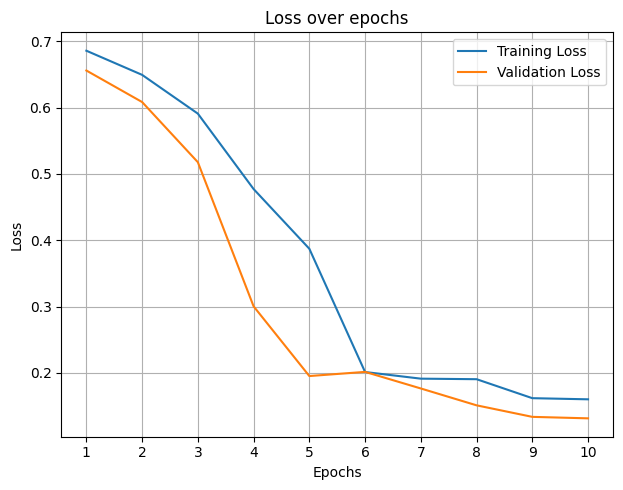

In [19]:
epochs_list = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Training Loss')
plt.plot(epochs_list, val_losses, label='Validation Loss')
plt.xticks(ticks=list(range(1, EPOCHS + 1, 1)))
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()


In [20]:
model_pth = model_path + 'my_checkpoint.pth'
trained_model = UNet(in_channels=3, num_classes=1).to(device)
trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

<ipython-input-20-800a6ad2bff5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


<All keys matched successfully>

In [21]:
test_running_loss = 0
test_running_dc = 0

with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = trained_model(img)
        loss = criterion(y_pred, mask)

        test_running_loss += loss.item()

    test_loss = test_running_loss / (idx + 1)

100%|██████████| 2/2 [00:09<00:00,  4.74s/it]


In [22]:
test_loss

0.3418462574481964

In [23]:
def random_images_inference(image_tensors, mask_tensors, model_pth, device):
    model = UNet(in_channels=3, num_classes=1).to(device)
    model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))

    #Procesando imagen de entrada
    transform = transforms.Compose([transforms.Resize((224, 224))])
    #Iterando sobre imágenes
    for image_pth, mask_pth in zip(image_tensors, mask_tensors):
        #Carga de la imagen de entrada
        img = transform(image_pth)
        #Segmentación de la imagen de entrada usando el modelo entrenado
        pred_mask = model(img.unsqueeze(0))

        print("pred_mask:", pred_mask.shape)
        pred_mask = pred_mask.squeeze(0).permute(1,2,0)

        # Carga de la máscara (etiqueta) para comparar
        mask = transform(mask_pth).permute(1, 2, 0).to(device)

        # Show the images
        img = img.cpu().detach().permute(1, 2, 0)
        pred_mask = pred_mask.cpu().detach()
        #pred_mask[pred_mask < 0] = 0
        pred_mask[pred_mask > 0] = 1

        plt.figure(figsize=(15, 16))
        plt.subplot(131), plt.imshow(img), plt.title("Original")
        plt.subplot(132), plt.imshow(pred_mask, cmap="gray"), plt.title("Predicción")
        plt.subplot(133), plt.imshow(mask, cmap="gray"), plt.title("Etiqueta")
        plt.show()

<class 'tuple'>


<ipython-input-23-44fb26788236>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


pred_mask: torch.Size([1, 1, 224, 224])


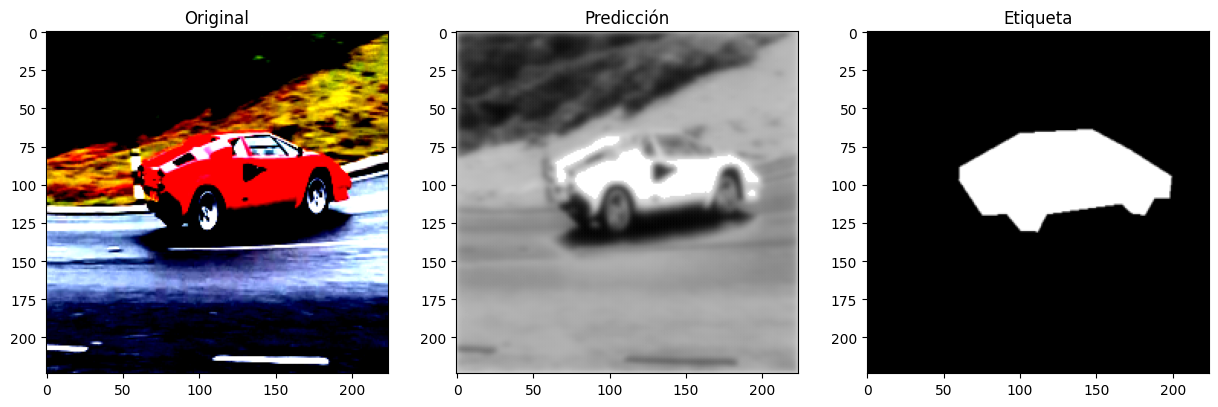

In [24]:
n = 1
image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(test_dataloader.dataset) - 1)
    random_sample = test_dataloader.dataset[random_index]
    print(type(random_sample))

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])

model_pth = model_path + 'my_checkpoint.pth'
random_images_inference(image_tensors, mask_tensors, model_pth, device="cpu")

## Visualizando máscaras durante el entrenamiento

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


<ipython-input-23-44fb26788236>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_pth, map_location=torch.device(device)))


pred_mask: torch.Size([1, 1, 224, 224])


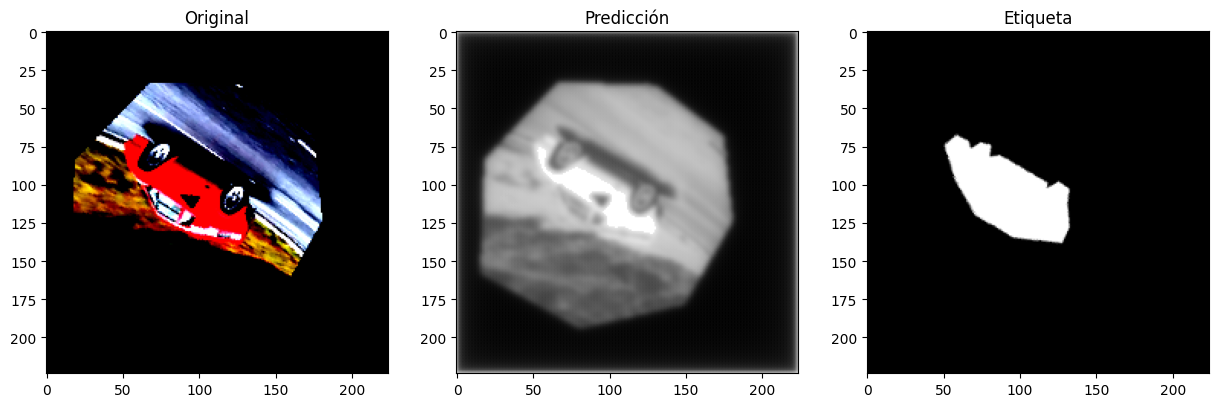

pred_mask: torch.Size([1, 1, 224, 224])


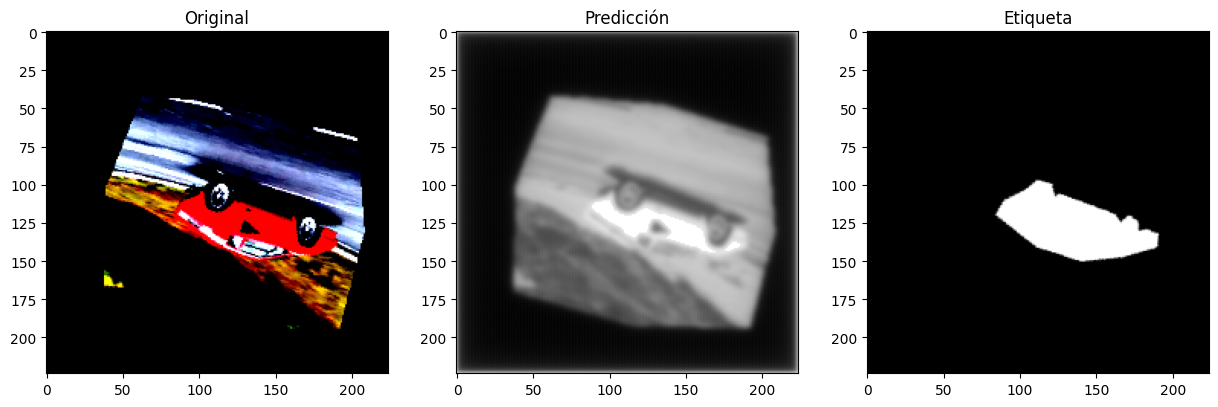

pred_mask: torch.Size([1, 1, 224, 224])


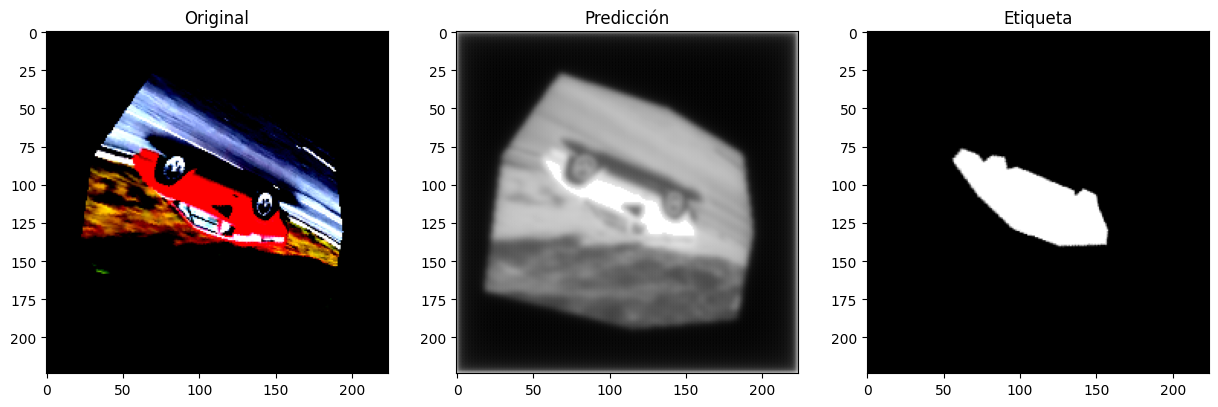

pred_mask: torch.Size([1, 1, 224, 224])


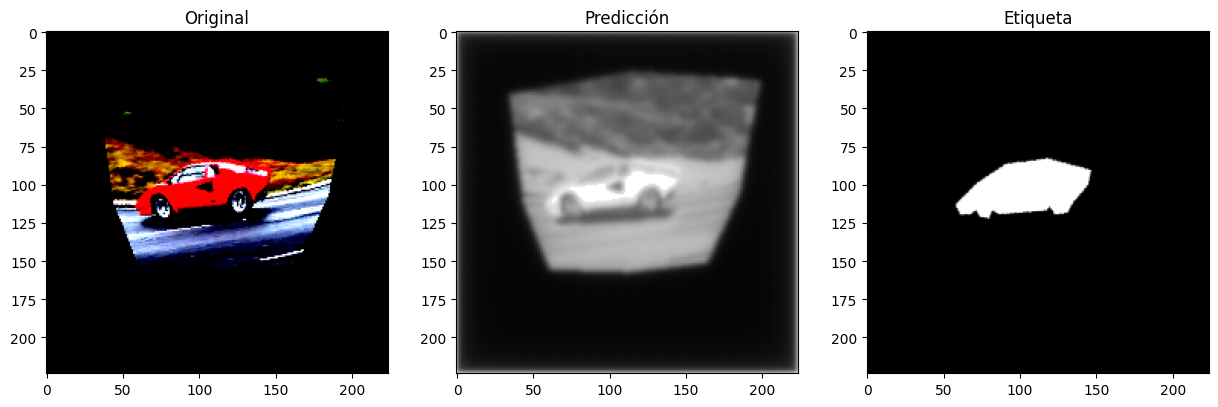

pred_mask: torch.Size([1, 1, 224, 224])


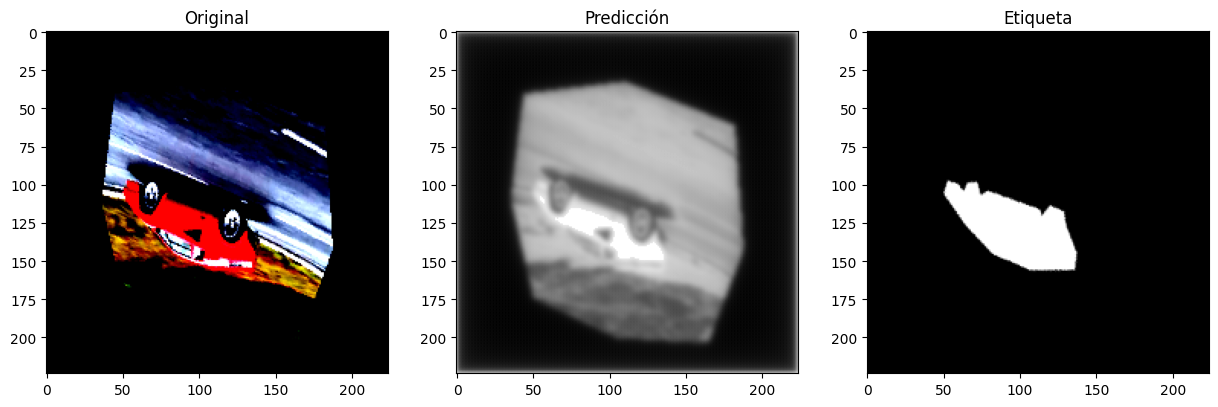

pred_mask: torch.Size([1, 1, 224, 224])


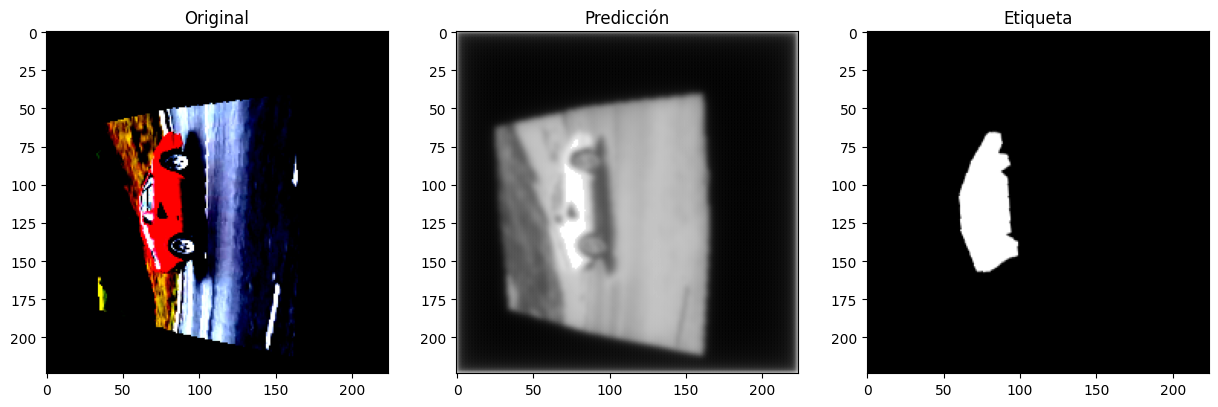

pred_mask: torch.Size([1, 1, 224, 224])


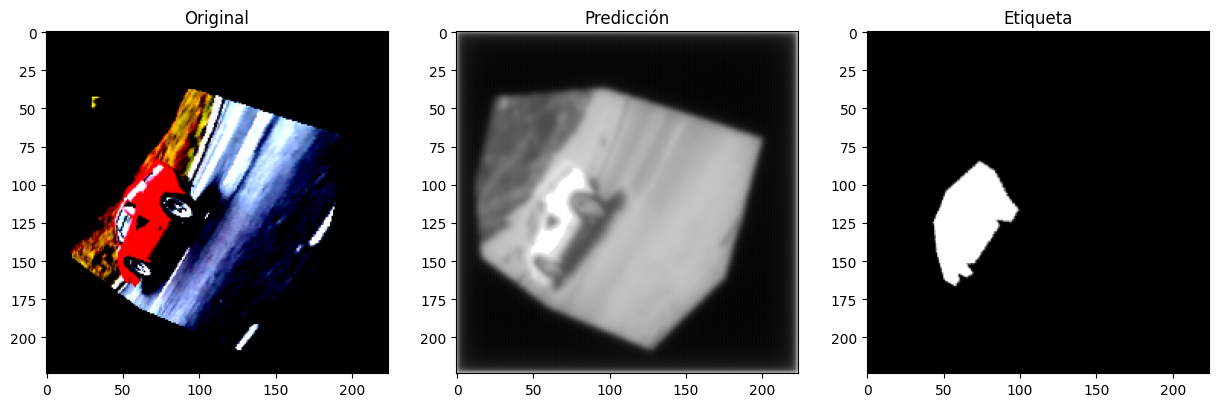

pred_mask: torch.Size([1, 1, 224, 224])


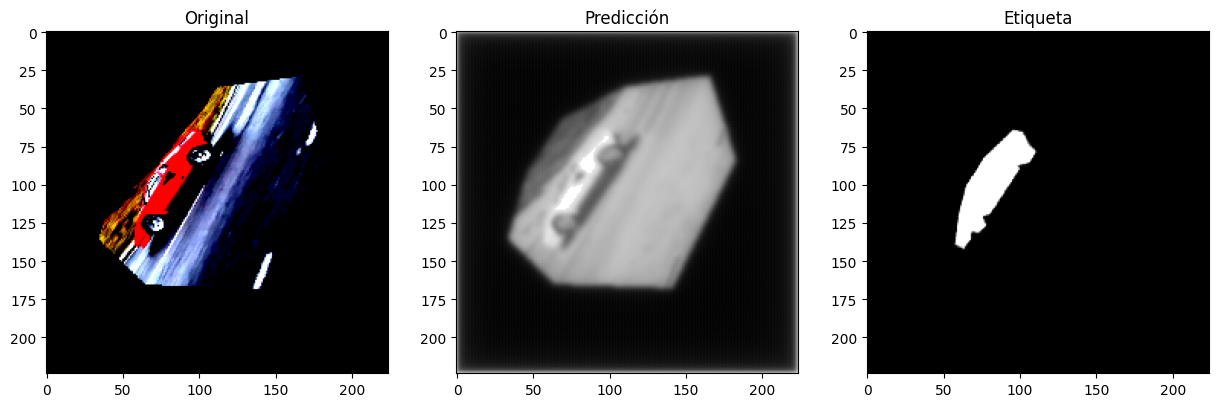

pred_mask: torch.Size([1, 1, 224, 224])


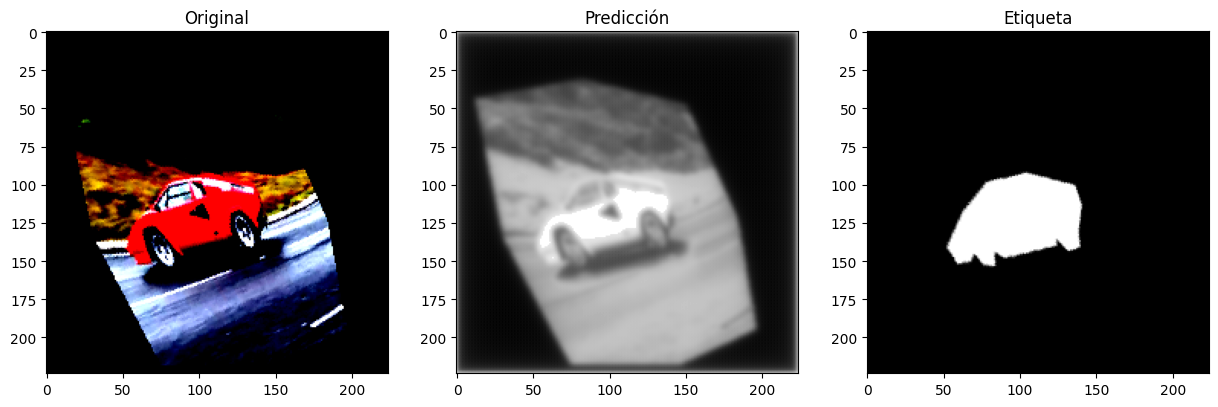

pred_mask: torch.Size([1, 1, 224, 224])


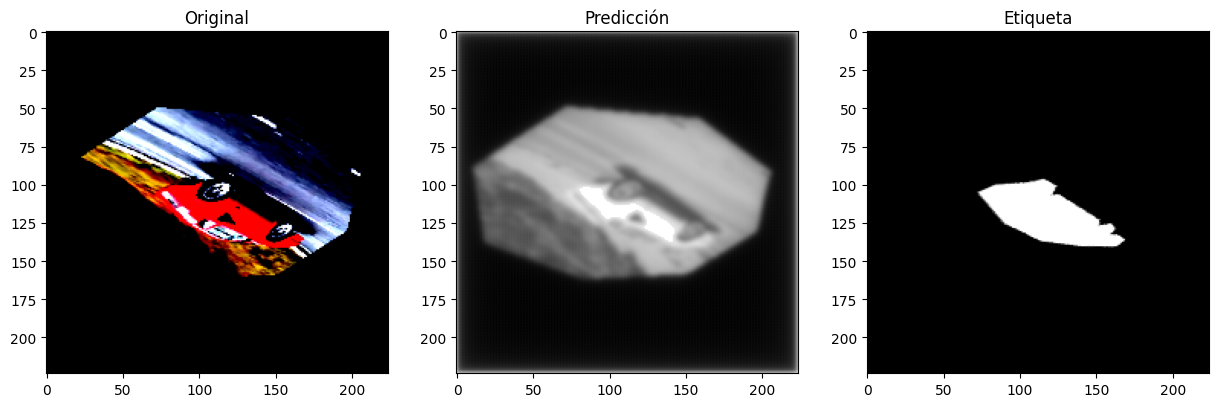

In [25]:
n = 10
image_tensors = []
mask_tensors = []
image_paths = []

for _ in range(n):
    random_index = random.randint(0, len(train_dataloader.dataset) - 1)
    random_sample = train_dataloader.dataset[random_index]
    print(type(random_sample))

    image_tensors.append(random_sample[0])
    mask_tensors.append(random_sample[1])

model_pth = model_path + 'my_checkpoint.pth'
random_images_inference(image_tensors, mask_tensors, model_pth, device="cpu")